The purpose of this notebook is to explore plotting drifters in each region, colour by drifter type.

In [1]:
import os
import datetime
import json
import glob
import yaml

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
from shapely.geometry import Point, Polygon
import xarray as xr


from driftutils import utils
from driftutils.assemble_drifter_metadata import assemble_drifter_metadata
from plotutils import plotting_utils as putils

%matplotlib inline

In [2]:
data_dir = '/home/jmm000/work/Drifters/output/TechReport2023/netcdf/'

In [3]:
assemble_drifter_metadata(data_dir, 'all_drifters.json')

In [4]:
with open('all_drifters.json', 'r') as f:
    metadata = json.load(f)

## Now explore plotting the regions

In [5]:
def load_polygon_coordinates(filename):
    '''Load the poylgon coordinate file and return a dictionary 
    with the shaplel Polygon for each region defined in the 
    coordinate file'''

    with open(filename, 'r') as f:
        poly_coords = yaml.safe_load(f)
    regions = {}
    for region in poly_coords['polygon_coords']:
        coords = poly_coords['polygon_coords'][region]
        new_coords = [(lon, lat) for lat, lon in coords ]
        regions[region] = Polygon(new_coords)
    return regions

In [6]:
def identify_drifters_region(region, metadata):
    drifters  = []
    for d in metadata['drifters']:
        launch_lat = float(d['first_latitude_observation'])
        launch_lon = float(d['first_longitude_observation'])
        launch_coord = Point((launch_lon, launch_lat))
        if launch_coord.within(region):
            drifters.append(d['filename'])
    return drifters

In [7]:
def plot_drifters_temp(drifter_files, ax, vmin=-1, vmax=25):
    types = []
    for drifter_file in drifter_files:
        d = xr.open_dataset(drifter_file)
        drifter_type = d.type
        if drifter_type not in types:
            types.append(drifter_type)
        if 'SST' not in d.variables:
            continue
        mesh = ax.scatter(d.LONGITUDE, d.LATITUDE, c=d.SST, 
                          transform=ccrs.PlateCarree(),
                         cmap='plasma', s=1, vmin=vmin, vmax=vmax,)
    return types, mesh

In [8]:
def plot_drifters_bp(drifter_files, ax, vmin=950,vmax=1050):
    types = []
    for drifter_file in drifter_files:
        d = xr.open_dataset(drifter_file)
        drifter_type = d.type
        if drifter_type not in types:
            types.append(drifter_type)
        if 'BP' not in d.variables:
            continue
        mesh = ax.scatter(d.LONGITUDE, d.LATITUDE, c=d.BP, 
                          transform=ccrs.PlateCarree(),
                          s=1,vmin=vmin,vmax=vmax)
    return types, mesh

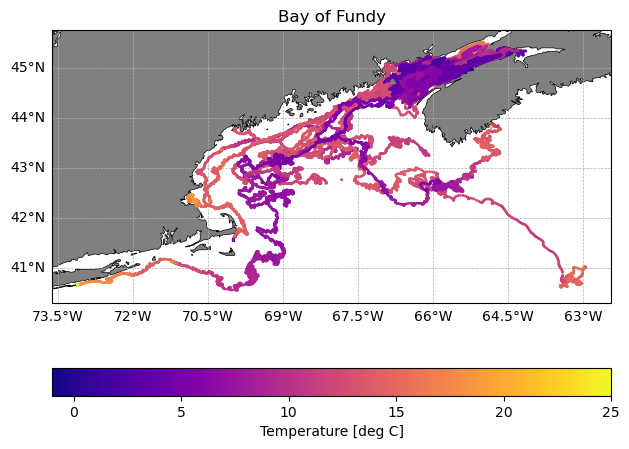

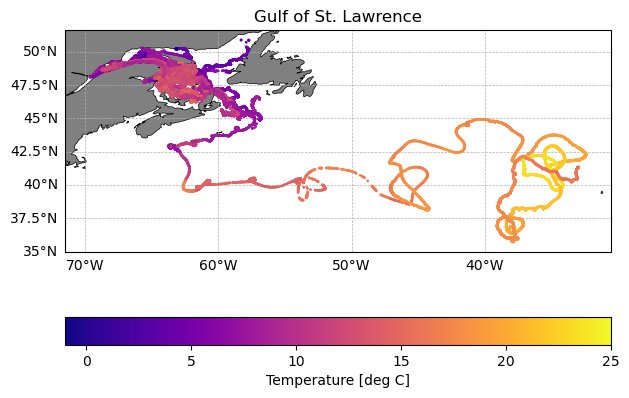

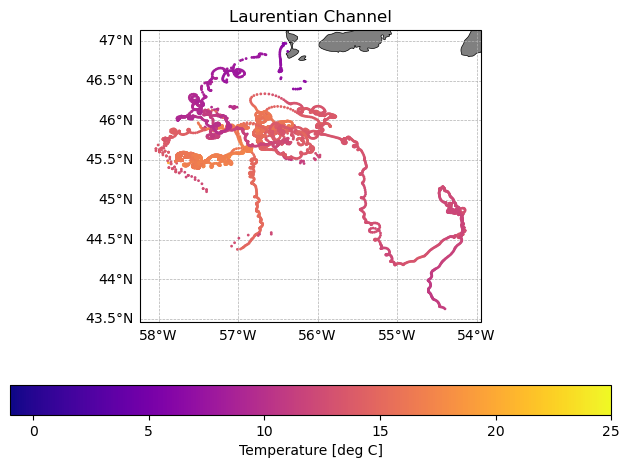

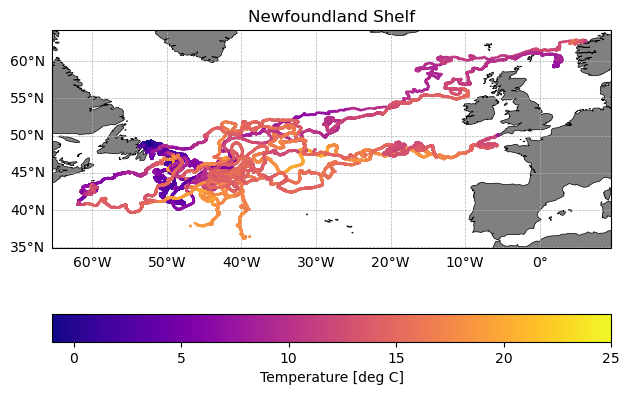

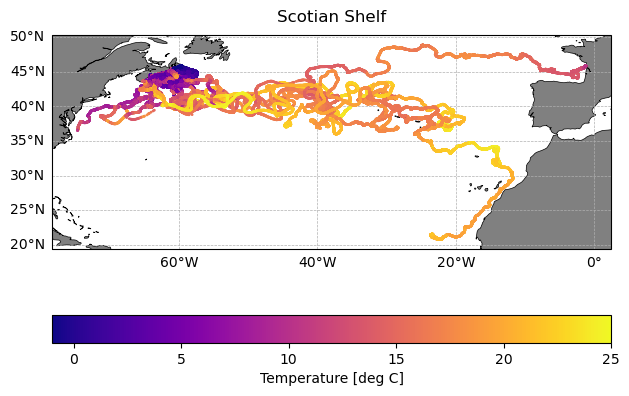

In [9]:

regions = load_polygon_coordinates('drifter-regions.yaml')

for region in regions:
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, )
    poly = regions[region]
    drifters = identify_drifters_region(poly, metadata)
    types, mesh = plot_drifters_temp(drifters, ax,)
    ax.set_title(region)
    ax.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.5,facecolor='gray')
    ax.gridlines(draw_labels=["bottom", "left"],zorder=0,linewidth=0.5, linestyle='--')
    cbar = plt.colorbar(mesh, ax=ax, location='bottom')
    cbar.set_label('Temperature [deg C]')
    fig.tight_layout()


In [10]:
all_files = [d['filename'] for d in metadata['drifters']]

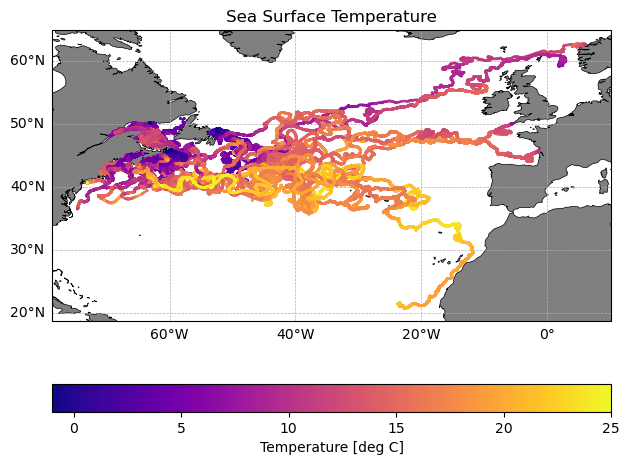

In [11]:
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, )
    types, mesh = plot_drifters_temp(all_files, ax,)
    ax.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.5,facecolor='gray')
    ax.gridlines(draw_labels=["bottom", "left"],zorder=0,linewidth=0.5, linestyle='--')
    ax.set_title('Sea Surface Temperature')
    cbar = plt.colorbar(mesh, ax=ax, location='bottom')
    cbar.set_label('Temperature [deg C]')
    fig.tight_layout()

In [12]:
fig.savefig('SeaSurfaceTemp.png', bbox_inches='tight', dpi=500)

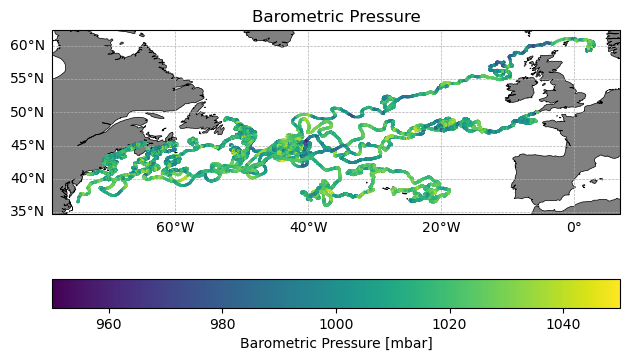

In [13]:
    fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, )
    types, mesh = plot_drifters_bp(all_files, ax,)
    ax.add_feature(cfeature.LAND, edgecolor='black', linewidth=0.5,facecolor='gray')
    ax.gridlines(draw_labels=["bottom", "left"],zorder=0,linewidth=0.5, linestyle='--')
    ax.set_title('Barometric Pressure')
    cbar = plt.colorbar(mesh, ax=ax, location='bottom')
    cbar.set_label('Barometric Pressure [mbar]')
    fig.tight_layout()

In [14]:
fig.savefig('BarometricPressure.png', bbox_inches='tight', dpi=500)